# Init

## Load necessary libraries. 
We suggest you use anaconda to setup a python 2 environment and install the following dependencies:
 * mdtraj https://anaconda.org/omnia/mdtraj
 * sklearn https://scikit-learn.org/stable/install.html
 * bio pandas https://anaconda.org/conda-forge/biopandas
 
Maybe I've missed some library. In that case please add it to the list

In [2]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
import mdtraj as md
from modules import utils, feature_extraction as fe, postprocessing, visualization
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("notebook")
working_dir = "/media/oliverfl/CHARMANDER/bachelor-thesis-2019/"  #TODO change directory
logger.info("Done with init")

2019-01-29 13:52:13 notebook-INFO: Done with init


## Load the MD trajectories
To use mdtraj, see http://mdtraj.org/latest/examples/introduction.html

There are currently **6** different simulations avaialable:
 * 3 simulations which have an agonist ligand (a drug favouring the active state) bound to the receptor. We call this __holo__
 
 
 * 3 simulations which have no ligand. We call this __apo__
 
 
 * 2 simulations (one holo; one apo) have the conserved residue Asp79 protonated (an extra proton). We call this __ash79__
 
 
 * 2 simulations (one holo; one apo) have Asp79 deprotonated but with a sodium ion forced next to it. We call this __asp79_Na__
 
 
 * 2 simulations (one holo; one apo; you get it now) have Asp79 deprotonated and no sodium force bound. We call this __asp79__. **Start with just these two!**
 
There is more data available in the directory 'longer'. If you need even more, tell me

In [3]:
traj_dir = working_dir + "string_trajectories/shorter/" #TODO change directory
holo_asp_traj = md.load(traj_dir + "asp79-apo-swarms-nowater-nolipid.xtc", 
                        top=traj_dir + "asp79-apo-swarms-nowater-nolipid.pdb") 
apo_asp_traj = md.load(traj_dir + "asp79-holo-swarms-nowater-nolipid.xtc", 
                        top=traj_dir + "asp79-holo-swarms-nowater-nolipid.pdb")  
logger.info("Loaded trajectories with properties %s, %s", holo_asp_traj, apo_asp_traj)

2019-01-29 13:52:14 notebook-INFO: Loaded trajectories with properties <mdtraj.Trajectory with 1293 frames, 4730 atoms, 364 residues, and unitcells>, <mdtraj.Trajectory with 1337 frames, 4783 atoms, 364 residues, and unitcells>


### Optional: select a subset om the atoms in the trajectory
See http://mdtraj.org/latest/examples/atom-selection.html 

In [4]:
#TODO

## Compute the interatomic distances for mdtrajectories
See http://mdtraj.org/1.6.2/api/generated/mdtraj.compute_contacts.html

In [5]:
holo_asp_distances, holo_asp_residue_pairs = md.compute_contacts(holo_asp_traj,
                                   contacts="all",
                                   scheme="closest-heavy", #You may want to use 'ca'
                                   ignore_nonprotein=True)
apo_asp_distances, apo_asp_residue_pairs = md.compute_contacts(apo_asp_traj,
                                   contacts="all",
                                   scheme="closest-heavy", #You may want to use 'ca'
                                   ignore_nonprotein=True)

if holo_asp_distances.shape[1] != apo_asp_distances.shape[1]:
    raise Exception("Different number of contacts in the two simulations. Must be the same")
logger.info("Done computing %s and %s distances", holo_asp_distances.shape)

Traceback (most recent call last):
  File "/home/oliverfl/anaconda2/envs/py2/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/home/oliverfl/anaconda2/envs/py2/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/home/oliverfl/anaconda2/envs/py2/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/home/oliverfl/anaconda2/envs/py2/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not enough arguments for format string
Logged from file <ipython-input-5-7208af5922bb>, line 12


## Merge this together into a data format suitable for training - samples and labels

Once you're done you want to train classifiers to predict the labels with the samples as input. i.e. based on the contacts in the protein, predict if it was apo or holo etc

In [10]:
samples = np.empty((len(holo_asp_distances) + len(apo_asp_distances), apo_asp_distances.shape[1]))
labels = np.empty((samples.shape[0],))
samples[0:len(holo_asp_distances)] = holo_asp_distances
samples[len(holo_asp_distances):] = apo_asp_distances
labels[0:len(holo_asp_distances)] = 1 #We label holo with '1' 
labels[len(holo_asp_distances):] = 2 # and apo with '2' 

feature_to_resids = np.empty((samples.shape[1], 2)) #This array tells us which residues the index of a certain feature correspond to. 
for feature_idx, (res1h, res2h) in enumerate(holo_asp_residue_pairs):
    res1a, res2a = apo_asp_residue_pairs[feature_idx]
    if res1h != res1a or res2h != res2a:
        raise Exception("Features differ at index %s. Must be aligned. (%s!=%s or %s!=%s)", feature_idx, res1h, res1a, res2h, res2a)
    else:
        feature_to_resids[feature_idx, 0] = res1h
        feature_to_resids[feature_idx, 1] = res2h        
logger.info("Done. Created samples of shape %s", samples.shape)

2019-01-29 13:58:47 notebook-INFO: Done. Created samples of shape (2630, 39621)


### Optional: save these as numpy npy files.
Then you can load them again in the future and skip the first steps

You can also split this notebook into two separate script - one which computes the distances and one which does feature extraction

In [ ]:
#TODO samples.save("xxxxx.npy) etc

# Feature extraction

Start by looking at the following 3 methods for classification:

** Random Forest (RF)**
 * Background: https://en.wikipedia.org/wiki/Random_forest
 * Implementation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
 
** Multilayer Perceptron (MLP)** 
 * The most time consuming one (probably)
 *Background: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
 * Implementation: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
 
** Kullback–Leibler (KL) Divergence **
 * see https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
 

In [12]:
n_iterations, n_splits = 1, 1 #Number of times to run and number of splits in cross validation
filter_by_distance_cutoff = False #Remove all distances greater than 0.5 nm (configurable limit). Typically residues close to each other contribute most to the stability of the protein
use_inverse_distances = True #Usually it is a good idea to take the inverse of the distances since a larg number then indicates two residues in contact -> stronger interaction

feature_extractors = [
     fe.MlpFeatureExtractor(samples, labels, n_splits=n_splits, n_iterations=n_iterations, 
                             hidden_layer_sizes=(100,), #You may need to tweak this
                             activation="relu", #use "relu" or logistic
                             randomize=True, # set to false for reproducability
                             filter_by_distance_cutoff=filter_by_distance_cutoff),                         
     fe.RandomForestFeatureExtractor(samples, labels, n_splits=n_splits, n_iterations=n_iterations,
                             filter_by_distance_cutoff=filter_by_distance_cutoff),
     fe.KLFeatureExtractor(samples, labels, n_splits=n_splits,
                            filter_by_distance_cutoff=filter_by_distance_cutoff),    
############ Unsupervised learning methods, skip them for a start#######################
#      fe.RbmFeatureExtractor(rbm_data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
#                           n_components=8,
#                            use_inverse_distances=use_inverse_distances,
#                           filter_by_distance_cutoff=filter_by_distance_cutoff),    
#      fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits,
#                            filter_by_distance_cutoff=filter_by_distance_cutoff),    
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2019-01-29 13:58:56 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (100,), solver lbfgs, activation function relu, randomize True, training_max_iter 100000
2019-01-29 13:58:56 RF-DEBUG: Initializing RF with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_estimators 30, njobs -1
2019-01-29 13:58:56 KL divergence-DEBUG: Initializing KL with the following parameters:                       n_splits 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       bin_size None
2019-01-29 13:58:56 notebook-INFO: Done. using 3 feature extractors


## Run feature extraction - this may take a little while

Every feature extractor will contain the "raw" data, the relevance per feature. For KL and MLP you will also get the relevance for apo and holo separately. For MLP you can even get it per frame, but that requires some code change I think

In [13]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")

2019-01-29 13:58:58 notebook-INFO: Computing relevance for extractors MLP
2019-01-29 13:58:58 Extracting features-INFO: Performing feature extraction with MLP on data of shape (2630, 39621)
2019-01-29 13:59:07 Extracting features-INFO: Using all data in training and validation sets
2019-01-29 13:59:08 mlp-DEBUG: Training MLP with 2630 samples and 39621 features ...
2019-01-29 13:59:31 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-29 13:59:35 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-01-29 13:59:35 Extracting features-INFO: Done with MLP
2019-01-29 13:59:35 Extracting features-INFO: ------------------------------
2019-01-29 13:59:36 notebook-INFO: Computing relevance for extractors RF
2019-01-29 13:59:36 Extracting features-INFO: Performing feature extraction with RF on data of shape (2630, 39621)
2019-01-29 13:59:45 Extracting features-INFO: Using all data in training and validation sets
2019-01-29 13:59:46 R

# Postprocessing

Again, you may want to save the relevance as npy files for faster access in the future

## Now use the computed relevance and postprocess them to something more useful

Once you get the hang of it you might want to write your own code for postprocessing and visualization to get the results you're looking for

In [16]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, labels,
                                     working_dir  + "analysis/", 
                                     pdb_file=traj_dir + "/asp79-apo-swarms-nowater-nolipid.pdb", 
                                     feature_to_resids=feature_to_resids, 
                                     filter_results=True)
    p.average()
    p.evaluate_performance()
    p.persist()
    postprocessors.append([p])
logger.info("Done")


2019-01-29 14:00:30 utils-INFO: Rescaling feature importances ...
2019-01-29 14:00:30 filtering-INFO: Filtering feature importances by median ...
2019-01-29 14:00:31 utils-INFO: Rescaling feature importances ...
2019-01-29 14:00:31 utils-INFO: Rescaling feature importances ...
2019-01-29 14:00:31 projection-INFO: Scoring raw projections.
2019-01-29 14:00:32 postprocessing-WARNING: importance is None for residues set([4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,

## Visualize the results

2019-01-29 14:00:39 utils-INFO: Rescaling feature importances ...


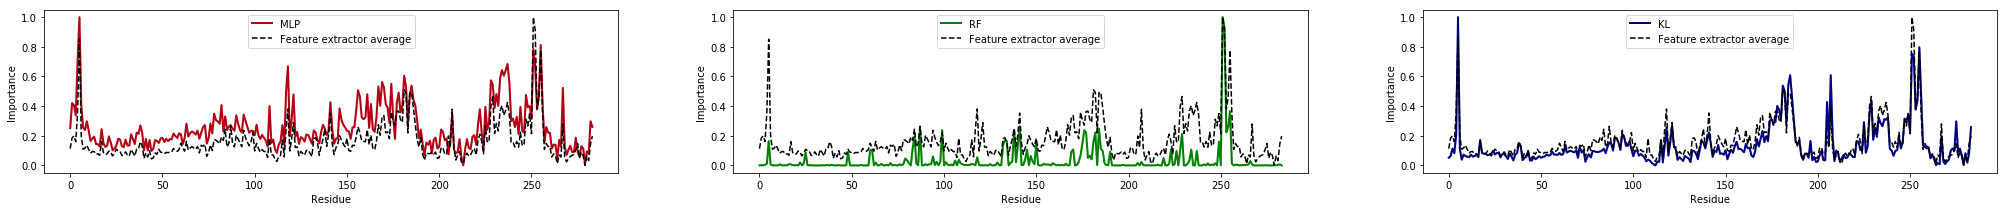

2019-01-29 14:00:39 notebook-INFO: Done. The settings were n_iterations, n_splits = 1, 1.
Filtering (filter_by_distance_cutoff = False)


In [17]:
visualization.visualize(postprocessors,
          show_importance=True, 
          show_performance=False, 
          show_projected_data=False)

logger.info("Done. The settings were n_iterations, n_splits = %s, %s.\nFiltering (filter_by_distance_cutoff = %s)", 
            n_iterations, n_splits, filter_by_distance_cutoff)

# Next steps
**1) Look at the generated structures and the trajectories** 
 * Spend some time on this and really get used to looking at 3D protein structures. 
 * Do these results make sense? I.e. the features picked up by the feature extractor, can you see how they change with visual inspection 
 
 
**2) Do more qualitative analysis** 
 * Read last year's bachelor thesis and look at what was done there 
 * What is the efffect of cross validation?
 * Do scatter plots for different features and see if you can easily make the different conditions cluster together. 
 
 
**3) Summarize work so far**
 * Write down the conclusions you've made so far
 * Save the plots and the protein structures for the report. 
 * If there are errors or it doesn't work at all, try and find the reason why
 
 
**4) Now go back and try to include more than just two conditions**
 * do multi class classfication, try and separate simulations with deprotonated Asp79 from neutrally charged Asp79 and so on ... 
 * You might not have time to look at everything so think carefully about what the most relevant/interesting questions to ask are based on your results so far. 
 * Iterate through the steps here until you get bored
 
**Optional work**
 * Try the methods for unsupervised learning, PCA and RBM specifically
 * Try even more methods for dimensionality reduction and feature extraction. There is a lot available in scikit learn
 * Use other types of features (dihedral angles, raw xyz coordinates, contacts with different cutoffs etc)  and compare
 